# DAS data loader and analyser
This notebook provides a demonstration on loading and analysising DAS data

In [1]:
# Import required libraries
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta,timezone
import glob
import os
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.signal import butter, filtfilt, firwin
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import tukey
from scipy.interpolate import interp1d
# from matplotlib.colors import LinearSegmentedColomap
from matplotlib.ticker import AutoMinorLocator



# Set up matplotlib for inline plotting
%matplotlib inline

The below cell contains all the functions required for viewing and processing the DAS data

In [20]:
def extract_metadata(file_path):
    """Extract metadata from HDF5 file"""
    with h5py.File(file_path, "r") as hdf5_file:
        start_time = hdf5_file["header/time"][()]
        dt = hdf5_file["header/dt"][()]
        dx = hdf5_file["header/dx"][()]
        channels = hdf5_file["header/channels"][()]
        # Get the actual number of samples in the file
        num_samples = hdf5_file["data"].shape[0]
    return start_time, dt, dx, channels, num_samples

def fir_bandpass(data, lowcut, highcut, fs, numtaps=101):
    """FIR bandpass filter with Nyquist frequency check"""
    nyquist = 0.5 * fs
    if highcut >= nyquist:
        highcut = nyquist * 0.99
    taps = firwin(numtaps, [lowcut/nyquist, highcut/nyquist], pass_zero=False)
    return filtfilt(taps, [1.0], data, axis=-1)


def find_start_file(file_paths, start_time_str):
    """Find the first file at or after the specified start time (HHMMSS format)"""
    # Convert input time string to datetime.time object
    try:
        input_time = datetime.strptime(start_time_str, "%H%M%S").time()
    except ValueError:
        raise ValueError("Invalid time format. Please use HHMMSS format (e.g., 102030)")

    # Find all files that match the time pattern
    time_files = []
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        if filename.endswith('.hdf5'):
            time_str = filename.split('.')[0]
            try:
                file_time = datetime.strptime(time_str, "%H%M%S").time()
                time_files.append((file_time, file_path))
            except ValueError:
                continue

    if not time_files:
        raise ValueError("No valid time-based HDF5 files found in the directory")

    # Sort files by time
    time_files.sort()

    # Find the first file at or after the requested time
    for file_time, file_path in time_files:
        if file_time >= input_time:
            return file_path, time_files.index((file_time, file_path))

    # If we get here, all files are before requested time - return last file
    return time_files[-1][1], len(time_files) - 1

def compute_spectrogram(signal, fs, Nfft=2048, overlap=0.9, file_time=None):
    """Compute spectrogram using matplotlib's specgram function"""
    Nover = int(np.floor(Nfft * overlap))
    pspect, fspect, tspect = plt.mlab.specgram(
        signal,
        NFFT=Nfft,
        Fs=fs,
        window=np.hanning(Nfft),
        noverlap=Nover,
        mode="psd",
    )
    psd = 10 * np.log10(pspect)
    if file_time:
        tspect_utc = [datetime.fromtimestamp(file_time) + timedelta(seconds=t) for t in tspect]
    else:
        tspect_utc = tspect
    return np.array(tspect_utc), fspect, psd

def load_and_join_data(input_directory, channel_step, start_time=None, end_time=None):
    """
    Load and concatenate data from HDF5 files within a specified time range.

    Parameters
    ----------
    input_directory : str
        Folder containing the HDF5 DAS files.
    channel_step : int
        Spatial downsampling factor.
    start_time, end_time : str, optional
        Start and end times in HHMMSS format. If None, load all available data.

    Returns
    -------
    data : np.ndarray
        Concatenated DAS data.
    time_axis : list
        List of datetime objects for the time axis.
    dt : float
        Sampling interval.
    dx : float
        Spatial sampling interval.
    channels_array : np.ndarray
        Array of channel indices.
    """
    file_paths = sorted(glob.glob(os.path.join(input_directory, '*.hdf5')))

    if not file_paths:
        raise FileNotFoundError(f"No HDF5 files found in {input_directory}")

    # Find the start and end files based on the time window
    start_file_path = file_paths[0]
    end_file_path = file_paths[-1]
    start_file_index = 0
    end_file_index = len(file_paths) - 1

    if start_time:
        try:
            start_file_path, start_file_index = find_start_file(file_paths, start_time)
        except ValueError as e:
            print(f"Warning: Could not find start file for time {start_time}. Loading from the first file. Error: {e}")

    if end_time:
         # For the end time, we need to find files up to and including the one that contains the end time.
         # We can reuse find_start_file but logic needs adjustment to find the last file *before* the end time + 1 file.
         # A simpler approach for now is to iterate from the start file and stop when we pass the end time.
         try:
            end_datetime = datetime.strptime(end_time, "%H%M%S").time()
            temp_end_index = start_file_index
            for i in range(start_file_index, len(file_paths)):
                 filename = os.path.basename(file_paths[i])
                 if filename.endswith('.hdf5'):
                    time_str = filename.split('.')[0]
                    try:
                         file_time = datetime.strptime(time_str, "%H%M%S").time()
                         if file_time <= end_datetime:
                             temp_end_index = i
                         else:
                             break # Stop when we pass the end time
                    except ValueError:
                         continue
            end_file_index = temp_end_index

         except ValueError as e:
             print(f"Warning: Could not parse end time {end_time}. Loading up to the last file. Error: {e}")


    # Ensure end_file_index is not before start_file_index
    end_file_index = max(start_file_index, end_file_index)


    selected_file_paths = file_paths[start_file_index : end_file_index + 1]

    if not selected_file_paths:
        raise ValueError("No files selected based on the provided time window.")

    # Extract metadata from the first selected file
    file_start_time_unix, dt, dx, channels_array, _ = extract_metadata(selected_file_paths[0])

    all_data = []
    time_axis = []
    total_samples = 0

    for file_path in selected_file_paths:
        try:
            current_start_time_unix, current_dt, _, current_channels_array, current_num_samples = extract_metadata(file_path)
            if current_dt != dt:
                print(f"Warning: dt mismatch in {file_path}. Expected {dt}, got {current_dt}. Skipping file.")
                continue
            if not np.array_equal(current_channels_array, channels_array):
                 print(f"Warning: Channel mismatch in {file_path}. Skipping file.")
                 continue


            with h5py.File(file_path, 'r') as f:
                # Load all channels for the current file
                file_data = f['data'][:]

                # Downsample channels
                file_data_downsampled = file_data[:, ::channel_step]


                # Create time axis for this file
                file_start_datetime = datetime.utcfromtimestamp(current_start_time_unix)
                # Calculate times for each sample in the current file
                file_times_seconds = np.arange(current_num_samples) * current_dt
                file_times_datetime = [file_start_datetime + timedelta(seconds=float(t)) for t in file_times_seconds]

                all_data.append(file_data_downsampled)
                time_axis.extend(file_times_datetime)
                total_samples += file_data_downsampled.shape[0]

        except KeyError as e:
            print(f"Skipping file {file_path} due to error: {e}")
        except Exception as e:
            print(f"Skipping file {file_path} due to unexpected error: {e}")


    if not all_data:
        raise ValueError("No data could be loaded from the selected files.")

    # Concatenate data from all files
    data = np.concatenate(all_data, axis=0)


    return data, time_axis, dt, dx, channels_array[::channel_step]


# @title
# ==========================
#   F-K ANALYSIS IMPLEMENTATION (no filtering, fast log-y support)
# ==========================

def fk_analysis(input_directory,
                dmin_fk, dmax_fk,
                tmin_fk, tmax_fk,
                channel_step,
                fmax_fk,
                velocity_lines,
                log_freq=False,
                n_log_bins=800):
    """
    Perform F-K analysis (no filtering) and plot the spectrum.

    Parameters
    ----------
    input_directory : str
        Folder containing the HDF5 DAS files.
    dmin_fk, dmax_fk : float
        Cable section in km.
    tmin_fk, tmax_fk : str
        Time window in HHMMSS format.
    channel_step : int
        Spatial downsampling factor.
    fmax_fk : float
        Maximum frequency to display.
    velocity_lines : list
        Velocities in m/s to plot lines.
    log_freq : bool
        If True, resample frequencies to logarithmic spacing (faster log-y plotting).
    n_log_bins : int
        Number of bins for log frequency spacing.
    """
    # --- Load data ---
    data, time_axis, dt, dx, channels_array = load_and_join_data(
        input_directory, channel_step=channel_step,
        start_time=tmin_fk, end_time=tmax_fk
    )
    data = data.astype(np.float64)

    # --- Select cable section ---
    distances = channels_array * dx / 1000  # km
    dist_mask = (distances >= dmin_fk) & (distances <= dmax_fk)
    data_section = data[:, dist_mask]
    channels_section = channels_array[dist_mask]
    distances_section = distances[dist_mask]

    if data_section.shape[1] < 2:
        raise ValueError("Not enough channels in the selected cable section for F-K analysis!")

    # --- Remove mean ---
    #data_section -= np.mean(data_section, axis=0, keepdims=True)
    #data_section -= np.mean(data_section, axis=1, keepdims=True)
    #data_section -= np.median(data_section, axis=1, keepdims=True)
    #data_section -= np.mean(data_section, axis=1, keepdims=True)
    data_section -= np.median(data_section, axis=(0, 1), keepdims=True)

    # --- No bandpass filtering ---
    data_filtered = data_section

    # --- 2D Tukey window ---
    nt, nx = data_filtered.shape
    window_2d = tukey(nt, 0.2)[:, None] * tukey(nx, 0.2)[None, :]
    data_windowed = data_filtered * window_2d

    # --- Effective channel spacing ---
    dx_eff = (distances_section[1] - distances_section[0]) * 1000  # m

    # --- 2D FFT and power spectrum ---
    fk = np.fft.fftshift(np.fft.fft2(data_windowed))
    fk_power = np.abs(fk)**2 + 1e-12
    fk_db = 10*np.log10(fk_power)
    fk_db -= np.max(fk_db)

    # --- Frequency and wavenumber axes ---
    freqs = np.fft.fftshift(np.fft.fftfreq(nt, dt))
    k_vals = np.fft.fftshift(np.fft.fftfreq(nx, dx_eff))

    # --- Positive frequencies only ---
    pos_mask = freqs >= 0
    freqs_pos = freqs[pos_mask]
    fk_db_pos = fk_db[pos_mask, :]

    # --- Limit frequency range ---
    freq_mask = freqs_pos <= fmax_fk
    freqs_plot = freqs_pos[freq_mask]
    fk_plot = fk_db_pos[freq_mask, :]

    # --- Log frequency resampling ---
    if log_freq:
        f_start = max(freqs_plot[1], 1e-3)
        log_freqs = np.logspace(np.log10(f_start), np.log10(freqs_plot[-1]), n_log_bins)
        fk_log = np.zeros((len(log_freqs), fk_plot.shape[1]))
        for i in range(fk_plot.shape[1]):
            f_interp = interp1d(freqs_plot, fk_plot[:, i], bounds_error=False, fill_value=np.nan)
            fk_log[:, i] = f_interp(log_freqs)
        freqs_plot = log_freqs
        fk_plot = fk_log

    # --- Ensure all finite for plotting ---
    fk_plot = np.nan_to_num(fk_plot, nan=np.nanmin(fk_plot))

    # --- Adaptive color scale ---
    vmin_db = np.percentile(fk_plot, 5)
    vmax_db = np.percentile(fk_plot, 99)

    # --- Plot F-K ---
    plt.figure(figsize=(12, 8))
    im = plt.pcolormesh(k_vals, freqs_plot, fk_plot,
                        shading='gouraud', cmap='jet',
                        vmin=vmin_db, vmax=vmax_db)
    plt.colorbar(im, label='Power [dB]')
    plt.xlabel("Wavenumber [1/m]")
    plt.ylabel("Frequency [Hz]")
    plt.title(f"F-K Spectrum | Distance {dmin_fk}-{dmax_fk} km | Time {tmin_fk}-{tmax_fk}")
    plt.xlim(-0.04, 0.04)
    plt.ylim(0.001, fmax_fk)
    if log_freq:
        plt.yscale('log')

    # --- Velocity lines (same color ±) ---
    k_max = np.max(np.abs(k_vals))
    colors = plt.cm.tab10(np.linspace(0, 1, len(velocity_lines)))

    for idx, v in enumerate(velocity_lines):
        f_line = np.linspace(freqs_plot[0], freqs_plot[-1], 2000)
        k_line = f_line / v
        k_valid = np.where(np.abs(k_line) <= k_max, k_line, np.nan)
        color = colors[idx]
        plt.plot(k_valid,  f_line, '--', linewidth=1, color=color, label=f'{v} m/s ({np.arccos(1500/v)/np.pi*180:.2f})°')
        plt.plot(-k_valid, f_line, '--', linewidth=1, color=color)

    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Diagnostics ---
    print(f"F-K analysis completed:")
    print(f"  Cable section: {dmin_fk}-{dmax_fk} km, Channels: {len(channels_section)}")
    print(f"  Time window: {tmin_fk} - {tmax_fk}, Samples: {nt}")
    print(f"  Frequency range: {freqs_plot[0]:.3f} - {freqs_plot[-1]:.1f} Hz")
    print(f"  Wavenumber range: {k_vals[0]:.4f} - {k_vals[-1]:.4f} 1/m")

In [ ]:
# Define the directory containing your HDF5 files
directory= "/Users/hassepedersen/Desktop/Hasse DAS/DAS data/20240512/"


# Get all HDF5 files in the directory
file_paths = sorted(glob.glob(os.path.join(directory, '*.hdf5')))
print(len(file_paths))
if not file_paths:
    print(f"No HDF5 files found in {directory}")
else:
    # Extract metadata from the first file
    start_time, dt, dx, channels, num_samples = extract_metadata(file_paths[0])
    fs = 1/dt

    print("Metadata from first file:")
    print(f"Start time (Unix timestamp): {start_time}")
    print(f"Start time (UTC): {datetime.fromtimestamp(start_time, tz=timezone.utc)}")
    print(f"Sampling interval (dt): {dt} seconds")
    print(f"Spatial sampling (dx): {dx} meters")
    print(f"Number of channels: {len(channels)}")
    print(f"Samples per file: {num_samples}")
    print(f"Sampling frequency: {fs} Hz")
    print(f"File duration: {num_samples * dt} seconds")
    print(f"Total files available: {len(file_paths)}")
    print(f"Maximum duration available: {len(file_paths) * num_samples * dt} seconds")

35
Metadata from first file:
Start time (Unix timestamp): 1715505785.731
Start time (UTC): 2024-05-12 09:23:05.731000+00:00
Sampling interval (dt): 0.00125 seconds
Spatial sampling (dx): 1.0213001907746815 meters
Number of channels: 15624
Samples per file: 8000
Sampling frequency: 800.0 Hz
File duration: 10.0 seconds
Total files available: 35
Maximum duration available: 350.0 seconds


Based on the parameters provided above decide what data you want to read in.
**Note:** large datasets (e.g. large spatial extend and high sampling rate) might cause a crash as it exceeds the RAM allocation.


In [22]:
# Parameters for data processing
dmin_km = 0      # Minimum distance in km
dmax_km = 100   # Maximum distance in km
chunk_size = 35   # CONTROL THIS: Number of files to process (each file = 10 seconds)
sample_step = 1 # Temporal downsampling factor
channel_step = 10 # Spatial downsampling factor

# Process first file to get parameters
start_time, dt, dx, channels, _ = extract_metadata(file_paths[0])
fs = 1/dt
# Create distance axis
distance_array_m = (channels) * dx
distance_array_km = distance_array_m / 1000
dist_mask = (distance_array_km >= dmin_km) & (distance_array_km <= dmax_km)
distances = distance_array_km[dist_mask][::channel_step]

# Initialize data storage
all_data = []
time_axis = []

# Process multiple files based on chunk_size
for file_idx in range(min(chunk_size, len(file_paths))):
    file_path = file_paths[file_idx]

    file_start_time, file_dt, _, _, file_num_samples = extract_metadata(file_path)
    
    with h5py.File(file_path, 'r') as f:
        data = f['data'][::sample_step, dist_mask][:, ::channel_step]

        # Create proper time axis for this file
        num_samples = data.shape[0]
        file_duration = num_samples * file_dt * sample_step

        # Calculate absolute times for this file
        # file_start_datetime = datetime.utcfromtimestamp(file_start_time)
        file_start_datetime = datetime.fromtimestamp(file_start_time, tz=timezone.utc)

        time_deltas = np.arange(0, num_samples) * (file_dt * sample_step)
        file_times = [file_start_datetime + timedelta(seconds=float(t)) for t in time_deltas]

        all_data.append(data)
        time_axis.extend(file_times)

# Combine data from all files
if len(all_data) > 1:
    combined_data = np.vstack(all_data)
else:
    combined_data = all_data[0]

print(f"Processing {chunk_size} files ({chunk_size * 10} seconds)")
print(f"Raw data shape: {combined_data.shape}")
#print(f"Filtered data shape: {filtered_data.shape}")
print(f"Time points: {len(time_axis)}")
print(f"Distance points: {len(distances)}")
print(f"Total duration: {(time_axis[-1] - time_axis[0]).total_seconds():.1f} seconds")

Processing 35 files (350 seconds)
Raw data shape: (280000, 1563)
Time points: 280000
Distance points: 1563
Total duration: 350.0 seconds


Now plot the data that you imported

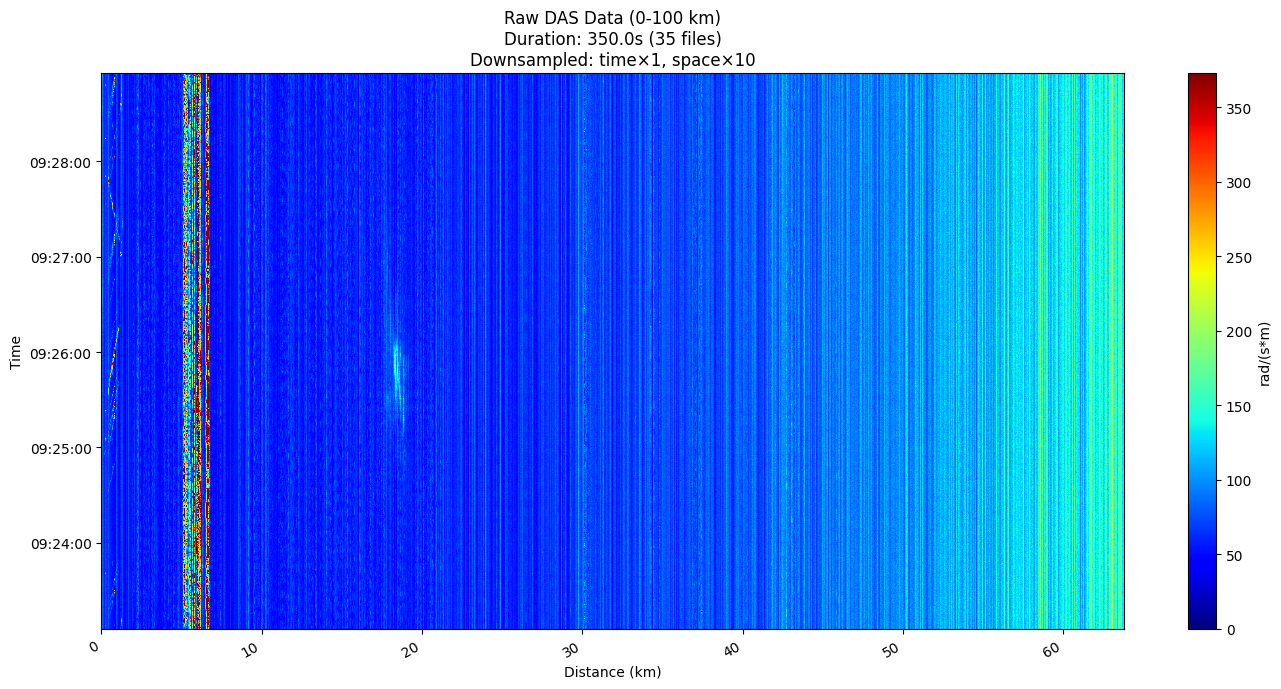

In [23]:
# Plot raw data (time-distance plot)
plt.figure(figsize=(14, 7))  # Wider figure for longer durations
vmax_amp = np.percentile(np.abs(combined_data), 99)


# Set extent with distances increasing from bottom to top
img = plt.imshow(abs(combined_data),
               aspect='auto',
               extent=[distances[0], distances[-1],
                       mdates.date2num(time_axis[0]),
                       mdates.date2num(time_axis[-1])],
               cmap='jet',
               vmin=-0,
               vmax=vmax_amp)

ax = plt.gca()
ax.yaxis_date()
ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()

plt.ylabel('Time')
plt.xlabel('Distance (km)')
duration_seconds = (time_axis[-1] - time_axis[0]).total_seconds()
plt.title(f'Raw DAS Data ({dmin_km}-{dmax_km} km)\n'
          f'Duration: {duration_seconds:.1f}s ({chunk_size} files)\n'
          f'Downsampled: time×{sample_step}, space×{channel_step}')
plt.colorbar(img, label='rad/(s*m)')
plt.tight_layout()
plt.show()

In the next cell there is the option to apply a filter to the data

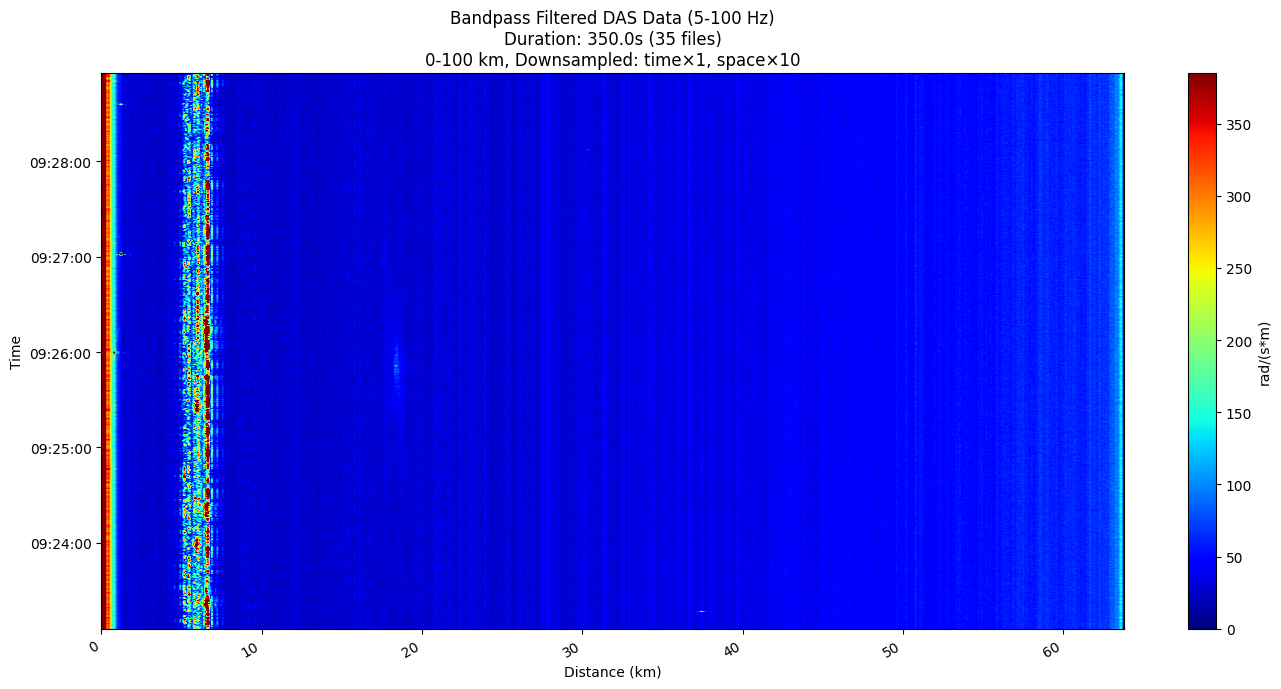

In [25]:
# Plot filtered data
lowcut = 5  # Low cutoff frequency for bandpass (Hz)
highcut = 100     # High cutoff frequency for bandpass (Hz)
max_perc_visual = 99 # Percentile of absolute amplitude in colormap

# Apply bandpass filter
filtered_data = fir_bandpass(combined_data, lowcut, highcut, fs)
plt.figure(figsize=(14, 7))  # Wider figure for longer durations
vmax_amp_filtered = np.percentile(filtered_data, max_perc_visual)

img = plt.imshow(abs(filtered_data),
               aspect='auto',
               extent=[distances[0], distances[-1],
                       mdates.date2num(time_axis[0]),
                       mdates.date2num(time_axis[-1])],
               cmap='jet',
               vmin=0,
               vmax=vmax_amp_filtered*2)

ax = plt.gca()
ax.yaxis_date()
ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()

plt.ylabel('Time')
plt.xlabel('Distance (km)')
duration_seconds = (time_axis[-1] - time_axis[0]).total_seconds()
plt.title(f'Bandpass Filtered DAS Data ({lowcut}-{highcut} Hz)\n'
          f'Duration: {duration_seconds:.1f}s ({chunk_size} files)\n'
          f'{dmin_km}-{dmax_km} km, Downsampled: time×{sample_step}, space×{channel_step}')
plt.colorbar(img, label='rad/(s*m)')
plt.tight_layout()
plt.show()


This filter is not always very good - try with a butterworth filter instead maybe

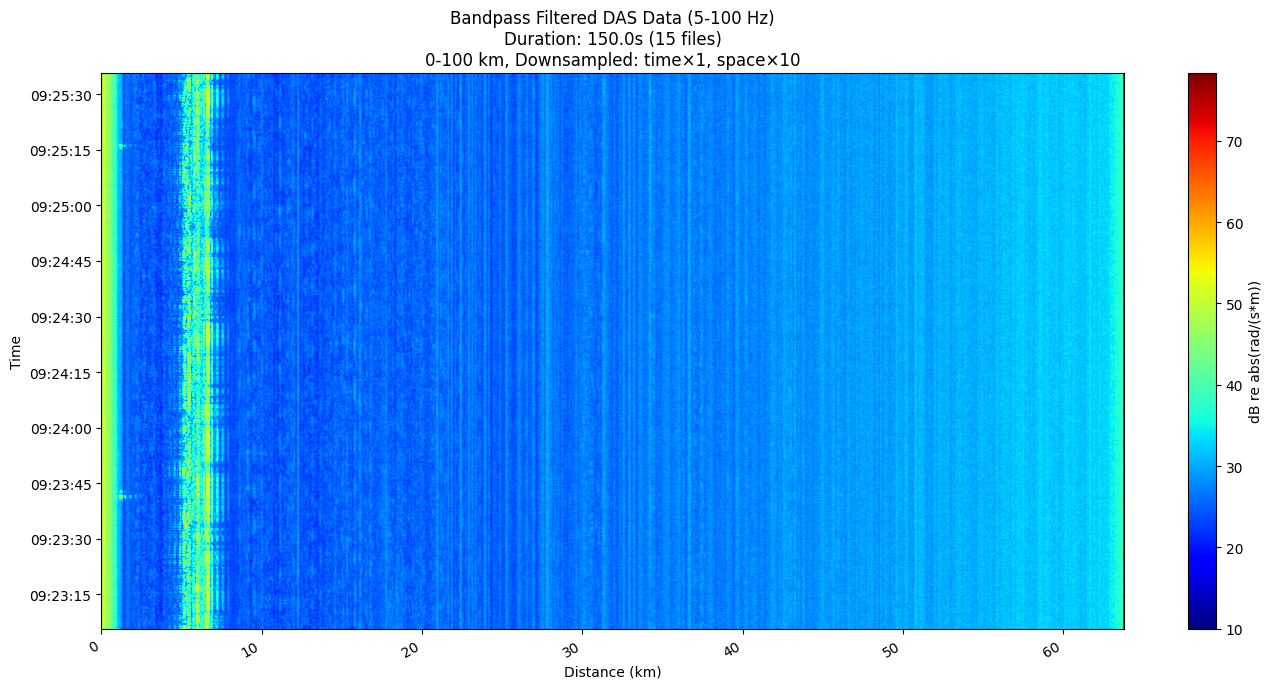

In [18]:

# Plot filtered data
plt.figure(figsize=(14, 7))  # Wider figure for longer durations
vmax_amp_filtered = np.percentile(20*np.log10(np.abs(filtered_data)), max_perc_visual)


img = plt.imshow(20*np.log10(np.abs(filtered_data)),
               aspect='auto',
               extent=[distances[0], distances[-1],
                       mdates.date2num(time_axis[0]),
                       mdates.date2num(time_axis[-1])],
               cmap='jet',
               vmin=10,
               vmax=vmax_amp_filtered*2)

ax = plt.gca()
ax.yaxis_date()
ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()

plt.ylabel('Time')
plt.xlabel('Distance (km)')
duration_seconds = (time_axis[-1] - time_axis[0]).total_seconds()
plt.title(f'Bandpass Filtered DAS Data ({lowcut}-{highcut} Hz)\n'
          f'Duration: {duration_seconds:.1f}s ({chunk_size} files)\n'
          f'{dmin_km}-{dmax_km} km, Downsampled: time×{sample_step}, space×{channel_step}')
plt.colorbar(img, label='dB re abs(rad/(s*m))')
plt.tight_layout()
plt.show()

Next we view the variation in frequency content with time using a spectrogram. For this we read in the raw data corrsponding to one location along the fibre. Relationship between `selected_channel`, let's call it c, and distance in meters down the cable d is: $$c = \frac{d}{5}$$

The duration in seconds ,t, is set by the `spectrogram_chunk_size` and is based on the formula: $$t = 10*chunk$$
This is based on the start of the record.


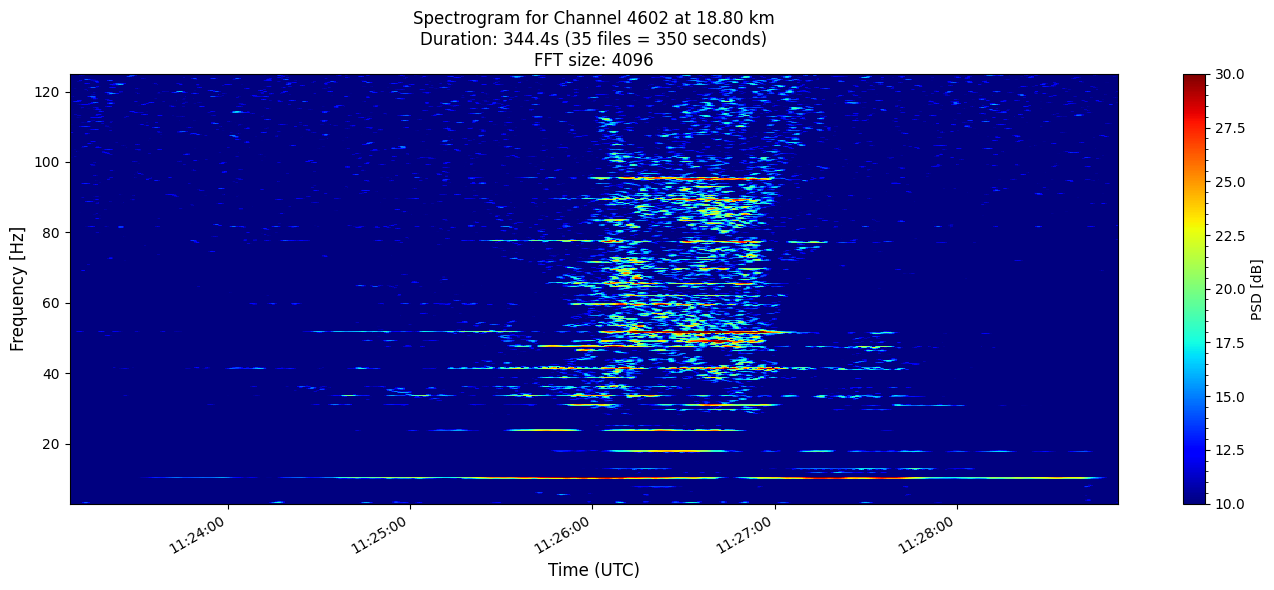

Spectrogram details:
Channel: 4602
Distance: 18.80 km
Number of files processed: 35
Total duration: 344.4 seconds
Data length: 280000 samples
FFT size: 4096
Frequency range: 0-125 Hz


In [ ]:
# Parameters for spectrogram
selected_channel = int(18800 /4.085)   # Change this to your desired channel  (here I choose 18800 corresponding to a ship)
spectrogram_chunk_size = 35  # CONTROL THIS: Number of files used in spectrogram (i.e. the duration)
fmax = 125              # Maximum frequency to display (Hz)
vmin_db = 10             # Minimum value for color scale (dB)
vmax_db = 30              # Maximum value for color scale (dB)

# Load data for the selected channel from MULTIPLE files
all_channel_data = []
file_start_time = None
dt = None
processed_files_count = 0

for i in range(min(spectrogram_chunk_size, len(file_paths))):
    file_path = file_paths[i]
    try:
        current_start_time, current_dt, dx, channels, num_samples = extract_metadata(file_path)

        # Store the start time from the first *successfully* processed file
        if file_start_time is None:
            file_start_time = current_start_time
            dt = current_dt

        with h5py.File(file_path, "r") as f:
            channel_data = f["data"][:, selected_channel]
            all_channel_data.append(channel_data)
        processed_files_count += 1
    except KeyError as e:
        print(f"Skipping file {file_path} due to error: {e}")
    except Exception as e:
        print(f"Skipping file {file_path} due to unexpected error: {e}")


# Check if any files were successfully processed
if not all_channel_data:
    print("No valid data could be loaded from the specified files.")
else:
    # Combine data from all selected files
    combined_data = np.concatenate(all_channel_data)
    fs = 1 / dt

    # Adjust FFT size based on duration
    total_duration_files = processed_files_count # Use the count of successfully processed files
    if total_duration_files <= 2:  # 20 seconds or less
        Nfft = 1024*4   # Better time resolution
    elif total_duration_files <= 6:  # 60 seconds or less
        Nfft = 1024*4  # Balanced resolution
    else:  # More than 60 seconds
        Nfft = 1024*4  # Better frequency resolution

    # Compute spectrogram
    tspect, fspect, psd = compute_spectrogram(
        combined_data,
        fs,
        Nfft=Nfft,
        overlap=0.9,
        file_time=file_start_time
    )

    # Plot spectrogram
    fig, ax = plt.subplots(figsize=(14, 6))  # Wider figure for longer duration

    # # Create custom colormap
    # colors = [(0,0,0.5), (0,0,1), (0,1,1), (1,1,0), (1,0,0), (0.5,0,0)]
    # cmap = LinearSegmentedColormap.from_list('custom_jet', colors)

    # Convert time objects to matplotlib date numbers for plotting
    tspect_num = mdates.date2num(tspect)

    # Create meshgrid for pcolormesh
    T, F = np.meshgrid(tspect_num, fspect)

    im = ax.pcolormesh(T, F, psd,
                      cmap="jet",
                      vmin=vmin_db,
                      vmax=vmax_db,
                      shading='auto')

    ax.set_xlabel("Time (UTC)", fontsize=12)
    ax.set_ylabel("Frequency [Hz]", fontsize=12)

    # Format x-axis with proper time display
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    fig.autofmt_xdate()

    # Calculate total duration
    duration = (tspect[-1] - tspect[0]).total_seconds()

    # Calculate distance for this channel
    channel_distance_km = channels[selected_channel] * dx / 1000

    ax.set_title(f"Spectrogram for Channel {selected_channel} at {channel_distance_km:.2f} km\n"
                f"Duration: {duration:.1f}s ({processed_files_count} files = {processed_files_count * 10} seconds)\n"
                f"FFT size: {Nfft}",
                fontsize=12)

    cbar = fig.colorbar(im, ax=ax, label="PSD [dB]")
    cbar.ax.yaxis.set_minor_locator(AutoMinorLocator())

    plt.ylim(3, fmax)
    plt.tight_layout()
    plt.show()

    # Print channel information
    print(f"Spectrogram details:")
    print(f"Channel: {selected_channel}")
    print(f"Distance: {channel_distance_km:.2f} km")
    print(f"Number of files processed: {processed_files_count}")
    print(f"Total duration: {duration:.1f} seconds")
    print(f"Data length: {len(combined_data)} samples")
    print(f"FFT size: {Nfft}")
    print(f"Frequency range: 0-{fmax} Hz")

Next we perform f-k analysis

**Note:** use small time windows and spatial distances as large values will cause a crash due to limited RAM. :(

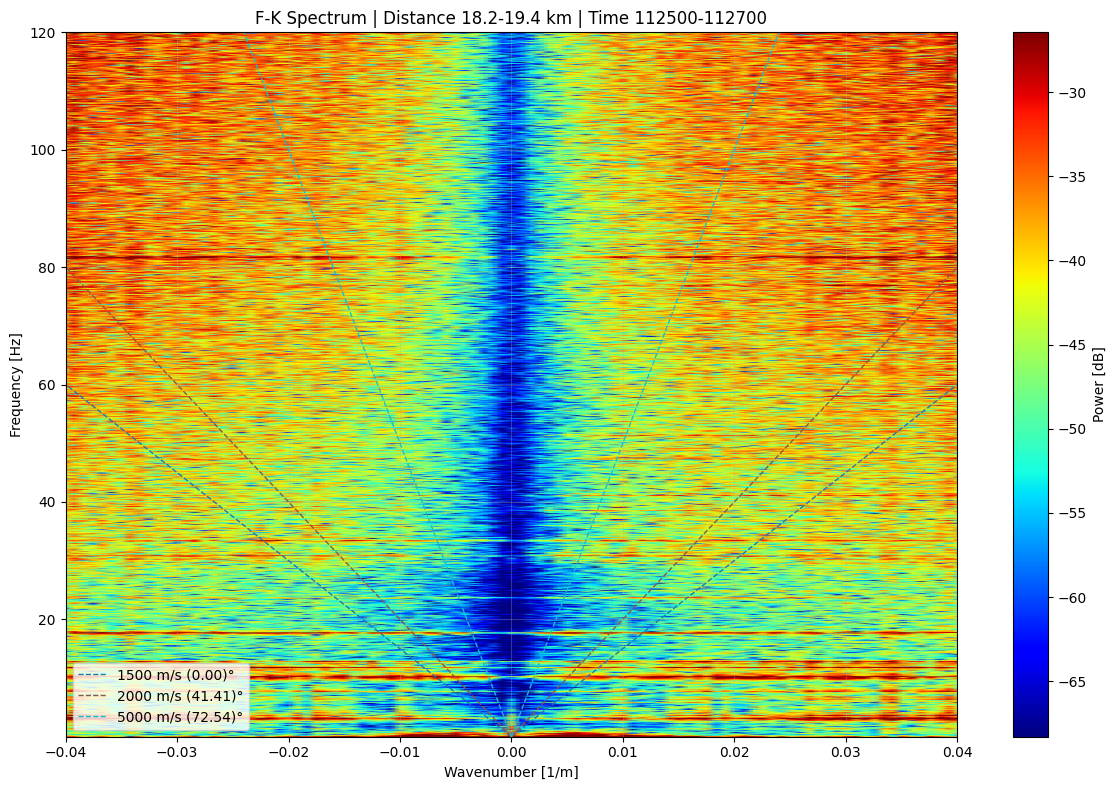

F-K analysis completed:
  Cable section: 18.2-19.4 km, Channels: 293
  Time window: 112500 - 112700, Samples: 8000
  Frequency range: 0.000 - 120.0 Hz
  Wavenumber range: -0.1220 - 0.1220 1/m


In [34]:
# ==========================
#   F-K ANALYSIS SETTINGS & USE
# ==========================
dmin_fk = 18.2   # km
dmax_fk = 19.4   # km
tmin_fk = "112500"#"035100" #"095630" #"204000" # start of time window, format is: HHMMSS
tmax_fk =  "112700"#"035130" #"095700" #"204030" # end of time window , same fromat
channel_step = 1
fmax_fk = 120
velocity_lines = [1500,2000, 5000]  # m/s

# Optional: log-frequency plot (faster rendering for log y-axis)
log_freq = False

# Run F-K analysis
fk_analysis(directory,
            dmin_fk, dmax_fk,
            tmin_fk, tmax_fk,
            channel_step,
            fmax_fk,
            velocity_lines,
            log_freq=log_freq)

/var/folders/3g/5r0fgqbs0_5993b7xgylgf740000gs/T/ipykernel_92281/1032530057.py:333: RuntimeWarning: invalid value encountered in arccos
  plt.plot(k_valid,  f_line, '--', linewidth=1, color=color, label=f'{v} m/s ({np.arccos(1500/v)/np.pi*180:.2f})°')


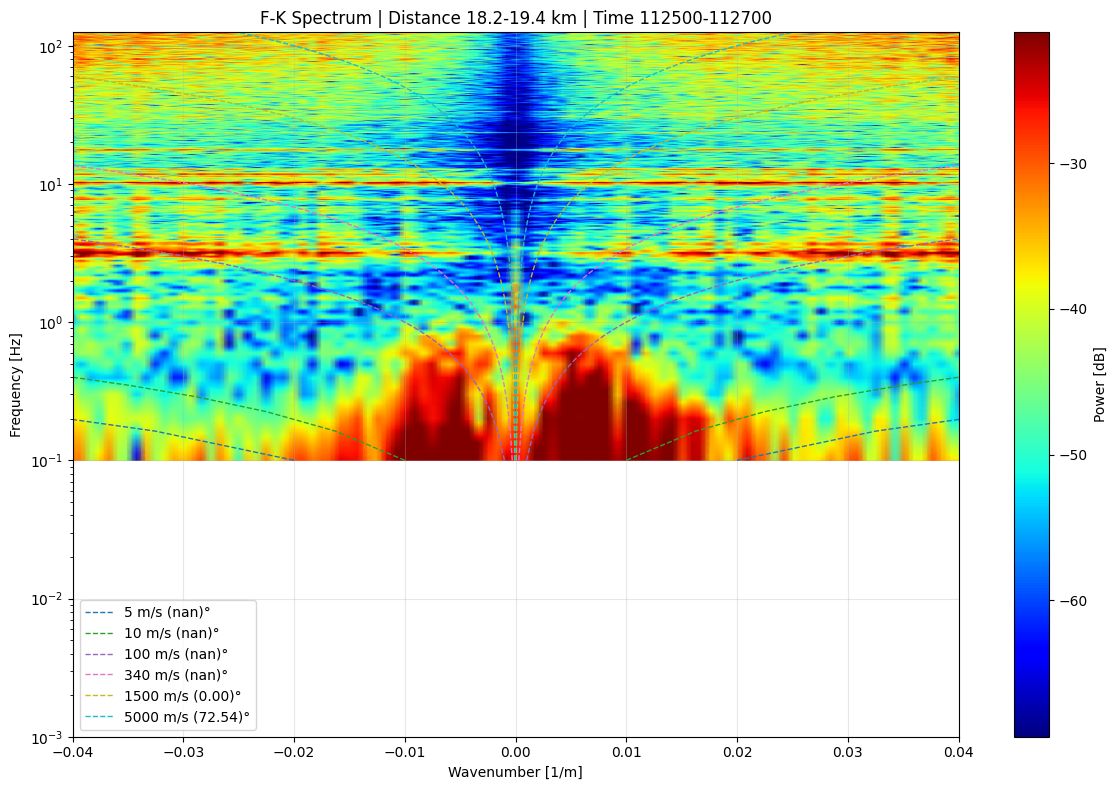

F-K analysis completed:
  Cable section: 18.2-19.4 km, Channels: 293
  Time window: 112500 - 112700, Samples: 8000
  Frequency range: 0.100 - 125.0 Hz
  Wavenumber range: -0.1220 - 0.1220 1/m


In [35]:
# ==========================
#   F-K ANALYSIS SETTINGS & USE
# ==========================
# dmin_fk = 1   # km
# dmax_fk = 2  # km
# tmin_fk = "203830"
# tmax_fk = "203930"

channel_step = 1
fmax_fk = 125
velocity_lines = [5,10,100,340,1500, 5000]  # m/s

# Optional: log-frequency plot (faster rendering for log y-axis)
log_freq = True

# Run F-K analysis
fk_analysis(directory,
            dmin_fk, dmax_fk,
            tmin_fk, tmax_fk,
            channel_step,
            fmax_fk,
            velocity_lines,
            log_freq=log_freq)